# Downscaling Temperature at GHI for **NYC Tristate** area

## Info:
This notebook includes the code to run a deep-learning based downscaling model using the dl4ds library on the SWDOWN variable. This variable, downward short wave flux at ground surface, is representative of the global horizaontal irradiance variable (GHI). Currently, this model does not include a predictor variable. 

**Variables:**
* DOWNWARD SHORT WAVE FLUX AT GROUND SURFACE (SWDOWN)

**Dataset Resolutions:**
* uWRF (Domain 02): 3-hourly, 3 km
* NAM: 3-hourly, 12 km

**Spatial Coverage:**
* 115,291.16 km²

# Import libraries

In [3]:
import xarray as xr
import numpy as np
import ecubevis as ecv
import scipy as sp
import netCDF4 as nc
import dl4ds as dds
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import models

In [4]:
!python --version

Python 3.8.18


In [5]:
import glob
import os
import re

directory = "/share/T3/sendo/coned/data3/nam/NAM-NMM/domnys_nc4"  # Change to your actual directory

# Find all files in the directory containing "2019"
files_with_2019 = glob.glob(f"{directory}/*2019*")

# Extract unique dates using regex
date_pattern = re.compile(r"_(\d{8})_")  # Matches an 8-digit date after an underscore
unique_dates = sorted(set(date_pattern.search(f).group(1) for f in files_with_2019 if date_pattern.search(f)))

# Print formatted output
print("# Storm Dates in 2019:\n")
for date in unique_dates:
    print(f"- {date}")

# Storm Dates in 2019:

- 20190220
- 20190221
- 20190222
- 20190223
- 20190224
- 20190225
- 20190226
- 20190227
- 20190228
- 20190301
- 20190302
- 20190303
- 20190521
- 20190522
- 20190523
- 20190524
- 20190525
- 20190526
- 20190527
- 20190528
- 20190529
- 20190530
- 20190531
- 20190601
- 20190602
- 20191011
- 20191012
- 20191013
- 20191014
- 20191015
- 20191016
- 20191017
- 20191018
- 20191019
- 20191020
- 20191021
- 20191022
- 20191023
- 20191024
- 20191025
- 20191026
- 20191027
- 20191028
- 20191029
- 20191030
- 20191031
- 20191101
- 20191102
- 20191103
- 20191104
- 20191105
- 20191106
- 20191107
- 20191126
- 20191127
- 20191128
- 20191129
- 20191130
- 20191201
- 20191202
- 20191203
- 20191204
- 20191205
- 20191206
- 20191207
- 20191208
- 20191209
- 20191210
- 20191211


# Define paths and retrieve files from server

In [6]:
uwrf_train = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/GHI/split/train/uWRF_final_01-02-03.nc')
uwrf_val = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/GHI/split/val/uWRF_final_04_first15days.nc')
uwrf_test = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/GHI/split/test/uWRF_final_04_first15days.nc')

nam_train = xr.open_dataset('/D4/data/gvaillant/NAM/2019/GHI/aligned-split/train/aligned_nam_train_data.nc')
nam_val = xr.open_dataset('/D4/data/gvaillant/NAM/2019/GHI/aligned-split/val/aligned_nam_val_data.nc')
nam_test = xr.open_dataset('/D4/data/gvaillant/NAM/2019/GHI/aligned-split/test/aligned_nam_test_data.nc')

# Using different visualization tool and calculating spatial coverage

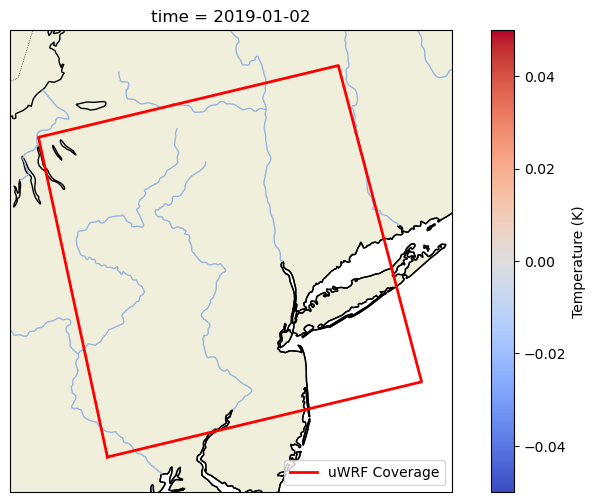

In [55]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Calculating min and max lat and lon
uwrf_min_lat = min(uwrf_train['latitude'].values)
uwrf_max_lat = max(uwrf_train['latitude'].values)
uwrf_min_lon = min(uwrf_train['longitude'].values)
uwrf_max_lon = max(uwrf_train['longitude'].values)

nam_min_lat = min(nam_train['latitude'].values)
nam_max_lat = max(nam_train['latitude'].values)
nam_min_lon = min(nam_train['longitude'].values)
nam_max_lon = max(nam_train['longitude'].values)

# Load the dataset
uwrf_train = xr.open_dataset('/D4/data/gvaillant/prep-uwrf/d02/GHI/split/train/uWRF_final_01-02-03.nc')

# Extract T2 for the first timestep
t2_first = uwrf_train['SWDOWN'].isel(time=8)

# Get spatial coverage
uwrf_min_lat = t2_first['latitude'].values.min()
uwrf_max_lat = t2_first['latitude'].values.max()
uwrf_min_lon = t2_first['longitude'].values.min()
uwrf_max_lon = t2_first['longitude'].values.max()

# Plotting with Cartopy
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.LambertConformal()})
ax.set_title("uWRF Dataset Coverage and T2 Field (First Time Step)", fontsize=14)

# Add coastlines and features
ax.coastlines(resolution='10m', color='black', linewidth=1)
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='none')
ax.add_feature(cfeature.RIVERS)

# Plot T2 data
t2_first.plot(ax=ax, transform=ccrs.LambertConformal(), cmap='coolwarm', cbar_kwargs={'label': 'Temperature (K)'})

# Add bounding box
ax.plot(
    [uwrf_min_lon, uwrf_min_lon, uwrf_max_lon, uwrf_max_lon, uwrf_min_lon],
    [uwrf_min_lat, uwrf_max_lat, uwrf_max_lat, uwrf_min_lat, uwrf_min_lat],
    color='red', transform=ccrs.PlateCarree(), linewidth=2, label='uWRF Coverage'
)

# Set extent for the map
ax.set_extent([uwrf_min_lon - 0.3, uwrf_max_lon + 0.3, uwrf_min_lat - 0.3, uwrf_max_lat + 0.3])

# Add legend
ax.legend(loc='lower right')

plt.show()


In [14]:
import numpy as np

def calculate_area(min_lat, max_lat, min_lon, max_lon):
    # Earth's radius in km
    R = 6371

    # Convert degrees to radians
    min_lat_rad = np.radians(min_lat)
    max_lat_rad = np.radians(max_lat)
    min_lon_rad = np.radians(min_lon)
    max_lon_rad = np.radians(max_lon)

    # Calculate differences
    delta_lat = max_lat_rad - min_lat_rad
    delta_lon = max_lon_rad - min_lon_rad

    # Area of a spherical rectangle segment
    area = (R**2) * delta_lon * (np.sin(max_lat_rad) - np.sin(min_lat_rad))
    return abs(area)

# uWRF area
uwrf_area = calculate_area(uwrf_min_lat, uwrf_max_lat, uwrf_min_lon, uwrf_max_lon)
print(f"uWRF Area: {uwrf_area:.2f} km²")

# NAM area
nam_area = calculate_area(nam_min_lat, nam_max_lat, nam_min_lon, nam_max_lon)
print(f"NAM Area: {nam_area:.2f} km²")

# Intersection area
intersection_area = calculate_area(
    max(uwrf_min_lat, nam_min_lat),
    min(uwrf_max_lat, nam_max_lat),
    max(uwrf_min_lon, nam_min_lon),
    min(uwrf_max_lon, nam_max_lon),
)
if intersection_area > 0:
    print(f"Intersection Area: {intersection_area:.2f} km²")
else:
    print("No overlap between the datasets.")


uWRF Area: 121205.96 km²
NAM Area: 115291.16 km²
Intersection Area: 115291.16 km²


# Define variables

In [17]:
#High resolution (uWRF) data
SWDOWN_hr_train = uwrf_train.SWDOWN
SWDOWN_hr_val = uwrf_val.SWDOWN
SWDOWN_hr_test = uwrf_test.SWDOWN

#--------------------------
#Low resolution (NAM) data
SWDOWN_lr_train = nam_train.SWDOWN
SWDOWN_lr_val = nam_val.SWDOWN
SWDOWN_lr_test = nam_test.SWDOWN


# Scale the data

In [18]:
SWDOWN_scaler_train = dds.StandardScaler(axis=None)
SWDOWN_scaler_train.fit(SWDOWN_hr_train)  

#----------------------------------------------
#High resolution (uWRF):
y_train = SWDOWN_scaler_train.transform(SWDOWN_hr_train)
y_val = SWDOWN_scaler_train.transform(SWDOWN_hr_val)
y_test = SWDOWN_scaler_train.transform(SWDOWN_hr_test)

#-------------------------------------------------
#Low resolution (NAM)

x_train = SWDOWN_scaler_train.transform(SWDOWN_lr_train)
x_val = SWDOWN_scaler_train.transform(SWDOWN_lr_val)
x_test = SWDOWN_scaler_train.transform(SWDOWN_lr_test)


# Compare original resolutions

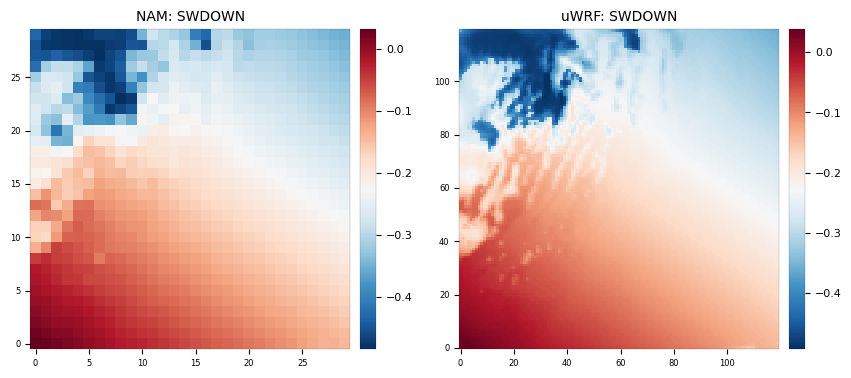

In [38]:
#SWDOWN: GHI
ecv.plot((x_train.values[7], y_train[7]), subplot_titles=('NAM: SWDOWN', 'uWRF: SWDOWN'))

Variable name: SWDOWN
Dimensionality: 3D
Shape: (2436, 30, 30)


<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
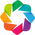

Column
    [0] WidgetBox(align=('center', 'start'))
        [0] DiscreteSlider(margin=(20, 20, 20, 20), name='verification t..., options=OrderedDict([('2019-01-01 ...]), value=numpy.datetime64('2019-01-..., width=250)
    [1] HoloViews(DynamicMap, height=400, sizing_mode='fixed', widget_location='top', width=400)

In [28]:
ecv.plot(x_train)

# Add channel dimension

In [39]:
y_train = y_train.expand_dims(dim='channel', axis=-1)
y_val = y_val.expand_dims(dim='channel', axis=-1)
y_test = y_test.expand_dims(dim='channel', axis=-1)

#-----------------------------------------------------

x_train = x_train.expand_dims(dim='channel', axis=-1)
x_val = x_val.expand_dims(dim='channel', axis=-1)
x_test = x_test.expand_dims(dim='channel', axis=-1)


# Verify shape

In [41]:
print("SWDOWN hr data shape:")
print(y_train.shape, y_val.shape, y_test.shape)
print("")

print("SWDOWN lr data shape:")
print(x_train.shape, x_val.shape, x_test.shape)

SWDOWN hr data shape:
(2436, 120, 120, 1) (406, 120, 120, 1) (435, 120, 120, 1)

SWDOWN lr data shape:
(2436, 30, 30, 1) (406, 30, 30, 1) (435, 30, 30, 1)


# Example coarsening method occuring during training:

For this model, we do not use the LR data (NAM) during training. Instead, we use a coarsened version (via interpolation) of the HR (uWRF) T2 and PSFC data. The DL4DS model carries out this interpolation on the fly by using the helper function dds.create_pair_hr_lr() (not to be called by the user). This process is done **automatically** inside the training loop (by calling one of the two (Supervised vs GAN) Trainer classes in DL4DS), which we examplify here with the spc upsampling. 

HR array: (120, 120, 1), LR array (30, 30, 1)


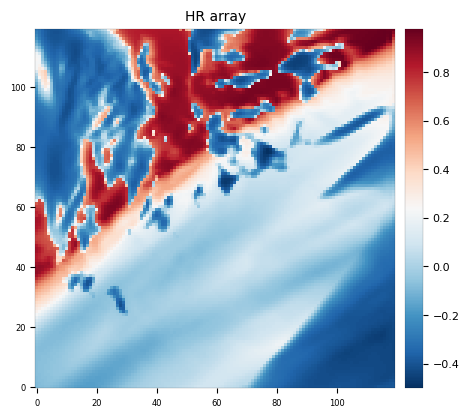

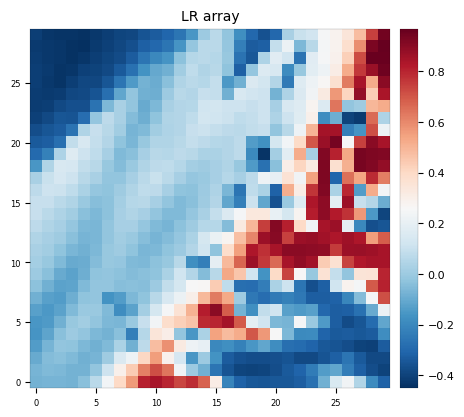

In [48]:
_ = dds.create_pair_hr_lr(y_train.values[5], None, 'spc', 4, None, None, None, None, True, interpolation='inter_area')

# Training Model

Possible backbones:

* resnet
* densenet
* convnet
* convnext

Running model with backbone=resnet
List of devices:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Number of devices: 1
Global batch size: 60
--------------------------------------------------------------------------------
Starting time: 2025-02-05 13:44:19
--------------------------------------------------------------------------------
Model: "resnet_spc"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                Output Shape                                 Param #        Connected to                                 
 input_1 (InputLayer)                        [(None, None, None, 1)]                      0              []                                           
                                                                                                                                                      
 conv2d (Conv2D) 

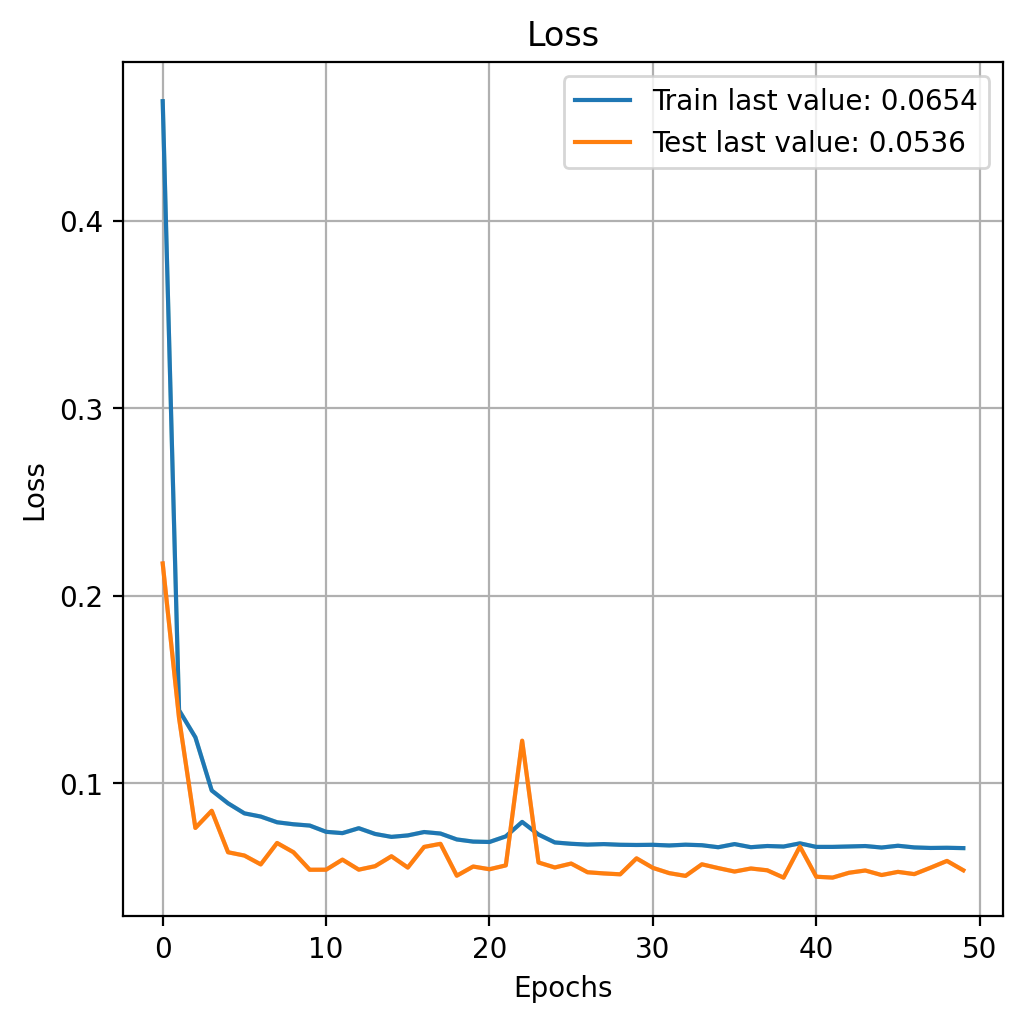

In [49]:
results = []
backbones = ['resnet']

for backbone in backbones:
    
    ARCH_PARAMS = dict(n_filters=8,
                       n_blocks=8,
                       normalization=None,
                       dropout_rate=0.5,
                       dropout_variant='spatial',
                       attention=False,
                       activation='relu',
                       localcon_layer=False)
    print(f"Running model with backbone={backbone}")



    trainer = dds.SupervisedTrainer(
        backbone=backbone,
        upsampling='spc', 
        data_train=y_train,
        data_val=y_val,
        data_test=y_test,
        data_train_lr=None, # here you can pass the LR dataset for training with explicit paired samples
        data_val_lr=None, # here you can pass the LR dataset for training with explicit paired samples
        data_test_lr=None, # here you can pass the LR dataset for training with explicit paired samples
        scale=4, 
        time_window=None, 
        static_vars=None,
        predictors_train=None,
        predictors_val=None,
        predictors_test=None,
        interpolation='inter_area',
        patch_size=None, 
        batch_size=60, #changed from 60
        loss='mae',
        epochs=50, 
        steps_per_epoch=None, 
        validation_steps=None, 
        test_steps=None, 
        learning_rate=(1e-3, 1e-4), lr_decay_after=1e4,
        early_stopping=False, patience=6, min_delta=0, 
        save=True, 
        save_bestmodel=True,
        save_path='/home/gvaillant1/downscaling/results/SWDOWN-Tristate-Model',
        show_plot=True, verbose=True, 
        device='CPU',
        **ARCH_PARAMS)
    trainer.run()


# Inference on uWRF test set

In [51]:
pred = dds.Predictor(
    trainer, 
    y_test, 
    scale=4, 
    array_in_hr=True,
    static_vars=None, 
    predictors=None, 
    time_window=None,
    interpolation='inter_area', 
    batch_size=64,
    scaler=SWDOWN_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_y_pred, coarsened_array = pred.run()

--------------------------------------------------------------------------------
Starting time: 2025-02-05 14:44:21
--------------------------------------------------------------------------------
7/7 [==============================] - 3s 321ms/step
--------------------------------------------------------------------------------
Final running time: 0:00:02.980716
--------------------------------------------------------------------------------


# Inference on NAM

In [52]:
pred1 = dds.Predictor(
    trainer, 
    x_train, 
    scale=4, 
    array_in_hr=False,
    static_vars=None, 
    predictors=None, 
    time_window=None,
    interpolation='inter_area', 
    batch_size=4,
    scaler=SWDOWN_scaler_train,
    save_path=None,
    save_fname=None,
    return_lr=True,
    device='CPU')

unscaled_x_pred, coarsened_array1 = pred1.run()

--------------------------------------------------------------------------------
Starting time: 2025-02-05 14:44:24
--------------------------------------------------------------------------------
609/609 [==============================] - 21s 35ms/step
--------------------------------------------------------------------------------
Final running time: 0:00:22.130198
--------------------------------------------------------------------------------


# Comparing predictions on uWRF test set

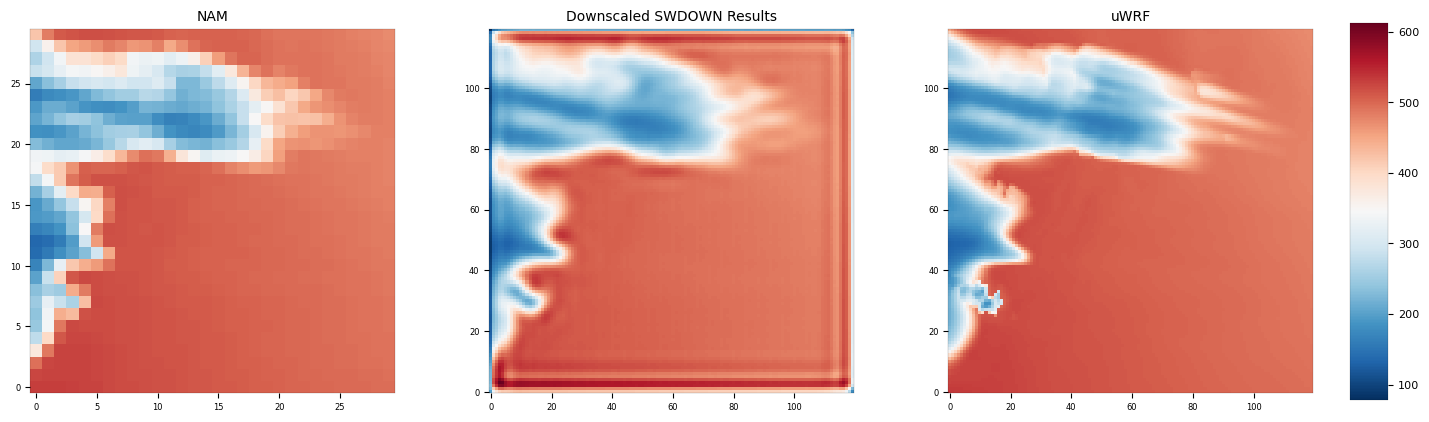

MAE for test set: 16.83138656616211


In [58]:
#is this the coarsened version hmm
unscaled_x_test = SWDOWN_scaler_train.inverse_transform(x_test)
unscaled_y_test = SWDOWN_scaler_train.inverse_transform(y_test)
ecv.plot((unscaled_x_test[7].values, unscaled_y_pred[7], unscaled_y_test[7].values),
         share_colorbar=True, share_dynamic_range=True, show_coastline=True, subplot_titles=('NAM', 'Downscaled SWDOWN Results', 'uWRF'))

mae = dds.losses.mae(unscaled_y_test[7].values, unscaled_y_pred[7])
print(f"MAE for test set: {mae}")

# Comparing predictions on NAM data 

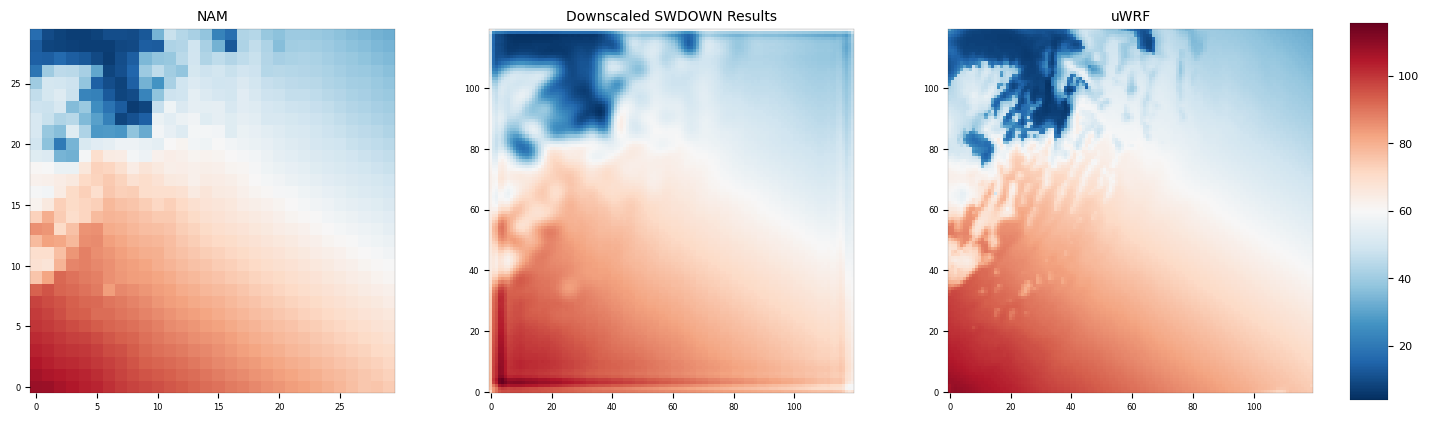

In [59]:
unscaled_x_train = SWDOWN_scaler_train.inverse_transform(x_train)
unscaled_y_train = SWDOWN_scaler_train.inverse_transform(y_train)
ecv.plot((unscaled_x_train[7].values, unscaled_x_pred[7], unscaled_y_train[7].values),
         share_colorbar=True, share_dynamic_range=True, subplot_titles=('NAM', 'Downscaled SWDOWN Results', 'uWRF'))

# Trying seperate visualization tool

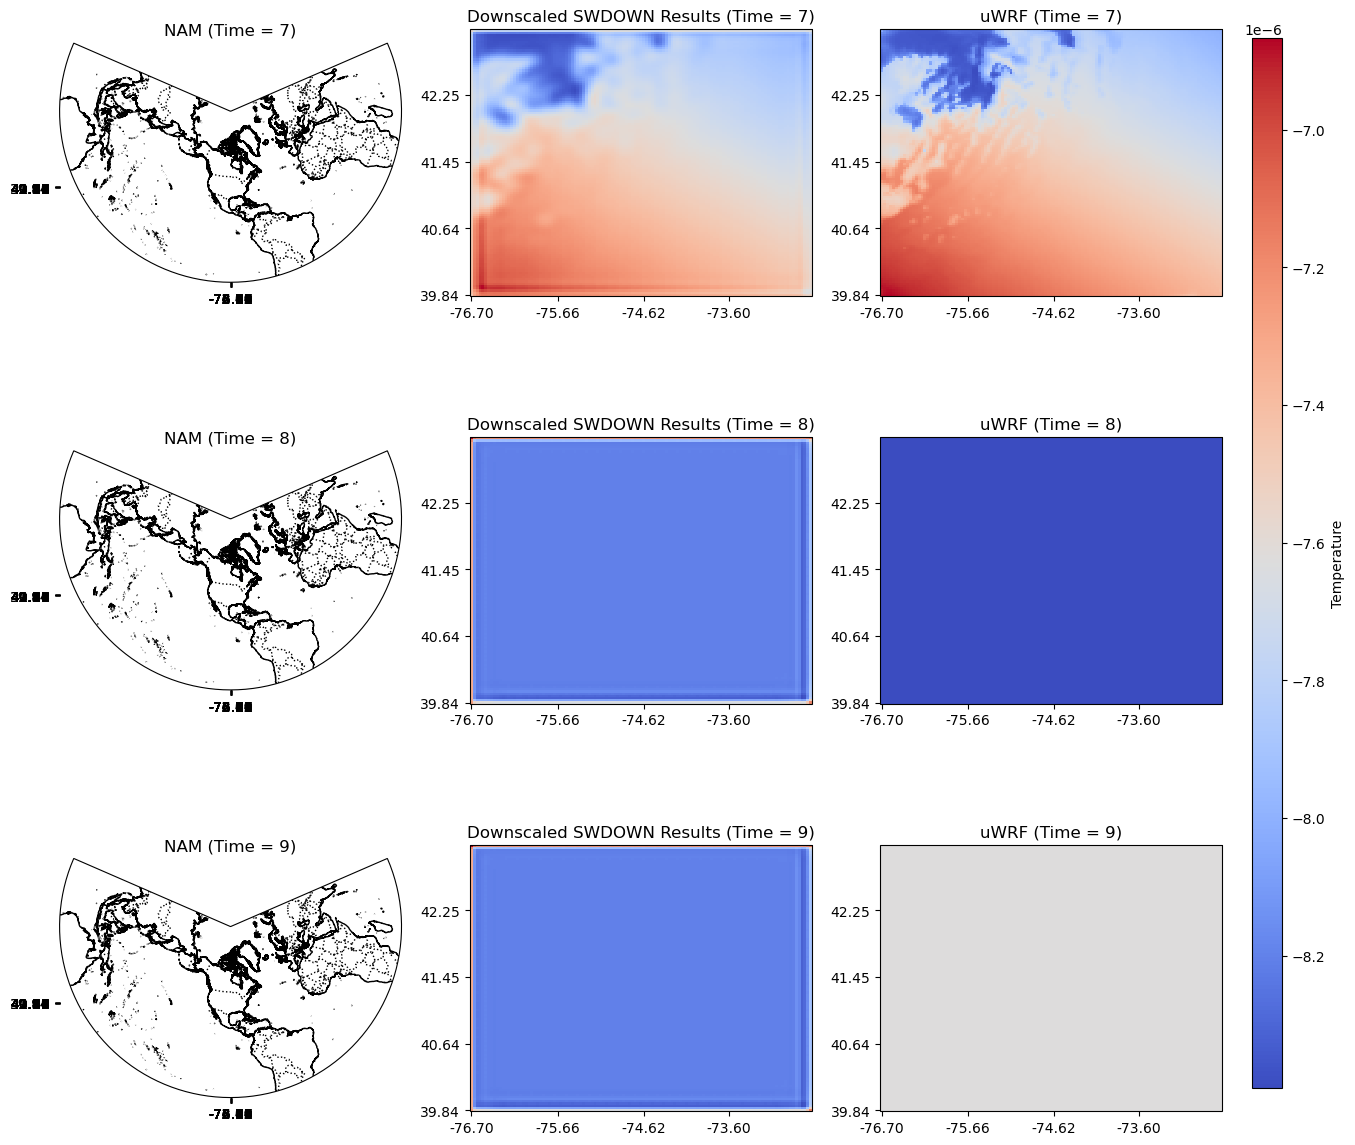

In [62]:
# Latitude and longitude for NAM
nam_lat = np.array([39.83631 , 39.943615, 40.05092 , 40.158245, 40.265556, 40.372875,
       40.480194, 40.587536, 40.69487 , 40.802197, 40.90954 , 41.016872,
       41.12421 , 41.23156 , 41.338894, 41.44624 , 41.553577, 41.660915,
       41.768246, 41.875576, 41.982914, 42.09025 , 42.19757 , 42.304882,
       42.41221 , 42.51952 , 42.626823, 42.73413 , 42.84143 , 42.948727])
nam_lon = np.array([-76.70499 , -76.56531 , -76.42578 , -76.28638 , -76.147095, -76.007965,
       -75.86896 , -75.7301  , -75.59137 , -75.45282 , -75.31436 , -75.176056,
       -75.03787 , -74.89984 , -74.76196 , -74.62421 , -74.48663 , -74.34918 ,
       -74.21185 , -74.07468 , -73.93765 , -73.80078 , -73.66403 , -73.527466,
       -73.39099 , -73.2547  , -73.11856 , -72.982544, -72.84671 , -72.711])

#extra lat: 40.93637, 40.963203, 40.99004
#extra lon: -73.66403, -73.62988, -73.5957
# Latitude and longitude for uWRF and downscaled data
uwrf_lat = np.array([
    39.83631 , 39.86314 , 39.88997 , 39.916782, 39.943615, 39.97044 ,
       39.997265, 40.0241  , 40.05092 , 40.07775 , 40.104576, 40.13141 ,
       40.158245, 40.18507 , 40.21189 , 40.23872 , 40.265556, 40.292385,
       40.319218, 40.34605 , 40.372875, 40.39971 , 40.426544, 40.453365,
       40.480194, 40.507034, 40.53387 , 40.5607  , 40.587536, 40.614372,
       40.64121 , 40.668037, 40.69487 , 40.7217  , 40.748535, 40.775364,
       40.802197, 40.829033, 40.85587 , 40.882706, 40.90954 , 40.93637 ,
       40.963203, 40.99004 , 41.016872, 41.043705, 41.07055 , 41.097378,
       41.12421 , 41.151054, 41.17788 , 41.20472 , 41.23156 , 41.25839 ,
       41.285217, 41.31206 , 41.338894, 41.365723, 41.39257 , 41.419403,
       41.44624 , 41.47307 , 41.499912, 41.52674 , 41.553577, 41.580418,
       41.607243, 41.63408 , 41.660915, 41.687748, 41.714584, 41.741417,
       41.768246, 41.79508 , 41.82192 , 41.848743, 41.875576, 41.90242 ,
       41.929253, 41.956085, 41.982914, 42.009743, 42.036575, 42.063416,
       42.09025 , 42.11707 , 42.1439  , 42.170734, 42.19757 , 42.2244  ,
       42.251232, 42.278053, 42.304882, 42.331726, 42.358555, 42.38538 ,
       42.41221 , 42.439037, 42.465866, 42.49269 , 42.51952 , 42.54635 ,
       42.573177, 42.60001 , 42.626823, 42.653652, 42.680485, 42.70731 ,
       42.73413 , 42.760956, 42.78778 , 42.81461 , 42.84143 , 42.868256,
       42.895073, 42.921898, 42.948727, 42.975536, 43.002365, 43.029186
])
uwrf_lon = np.array([
    -76.70499 , -76.670044, -76.63513 , -76.60022 , -76.56531 , -76.530396,
       -76.495514, -76.46063 , -76.42578 , -76.3909  , -76.35605 , -76.3212  ,
       -76.28638 , -76.251526, -76.216736, -76.181885, -76.147095, -76.112305,
       -76.077515, -76.042725, -76.007965, -75.973206, -75.938446, -75.90369 ,
       -75.86896 , -75.83423 , -75.79953 , -75.76483 , -75.7301  , -75.695435,
       -75.660736, -75.62604 , -75.59137 , -75.55673 , -75.522095, -75.48743 ,
       -75.45282 , -75.41818 , -75.383545, -75.34894 , -75.31436 , -75.279785,
       -75.24518 , -75.21063 , -75.176056, -75.14148 , -75.10693 , -75.07242 ,
       -75.03787 , -75.00336 , -74.96884 , -74.93436 , -74.89984 , -74.86536 ,
       -74.8309  , -74.79642 , -74.76196 , -74.72754 , -74.693085, -74.65863 ,
       -74.62421 , -74.58981 , -74.55542 , -74.520996, -74.48663 , -74.45224 ,
       -74.41788 , -74.383514, -74.34918 , -74.31482 , -74.28049 , -74.246155,
       -74.21185 , -74.17755 , -74.14325 , -74.10895 , -74.07468 , -74.040405,
       -74.006165, -73.97189 , -73.93765 , -73.90341 , -73.8692  , -73.83496 ,
       -73.80078 , -73.76657 , -73.73239 , -73.69821 , -73.66403 , -73.62988 ,
       -73.5957  , -73.561584, -73.527466, -73.49332 , -73.4592  , -73.42511 ,
       -73.39099 , -73.35693 , -73.322845, -73.28876 , -73.2547  , -73.22064 ,
       -73.186615, -73.15259 , -73.11856 , -73.08453 , -73.05054 , -73.01654 ,
       -72.982544, -72.94858 , -72.91461 , -72.88068 , -72.84671 , -72.812775,
       -72.77884 , -72.744934, -72.711   , -72.677124, -72.64322 , -72.609344
])

# Create latitude-longitude meshgrids
nam_lon_grid, nam_lat_grid = np.meshgrid(nam_lon, nam_lat)
uwrf_lon_grid, uwrf_lat_grid = np.meshgrid(uwrf_lon, uwrf_lat)

# Dynamically set rows to match the number of time steps
time_steps = [7, 8, 9]
num_time_steps = len(time_steps)
fig, axes = plt.subplots(num_time_steps, 3, subplot_kw={'projection': ccrs.LambertConformal()}, figsize=(15, 5 * num_time_steps))
titles = ['NAM', 'Downscaled SWDOWN Results', 'uWRF']

# Loop through time steps
for t_idx, i in enumerate(time_steps):
    # Extract data for the current time step
    nam_data = unscaled_x_train[i].values  # NAM data
    #nam_data = coarsened_array1[i]
    downscaled_data = unscaled_x_pred[i]  # Downscaled data
    uwrf_data = unscaled_y_train[i].values  # uWRF data

    # Loop through datasets for the current time step
    for j, (data, title) in enumerate(zip([nam_data, downscaled_data, uwrf_data], titles)):
        ax = axes[t_idx, j] if num_time_steps > 1 else axes[j]  # Handle single-row case
        
        if title == 'NAM':
            # Plot NAM data using imshow
            
            #im = ax.imshow(data, extent=[nam_lon.min(), nam_lon.max(), nam_lat.min(), nam_lat.max()],
                         #  transform=ccrs.PlateCarree(), cmap='coolwarm', origin='upper')
                           
            im = ax.imshow(data[::-1, :], extent=[nam_lon.min(), nam_lon.max(), nam_lat.min(), nam_lat.max()],
               transform=ccrs.PlateCarree(), cmap='coolwarm', origin='upper')


        else:
            # Plot higher-resolution data using pcolormesh
            im = ax.pcolormesh(uwrf_lon_grid, uwrf_lat_grid, data, transform=ccrs.LambertConformal(), cmap='coolwarm')
            #im = ax.pcolormesh(uwrf_lon_grid[:-1, :-1], uwrf_lat_grid[:-1, :-1], data[:16, :16],
                   #transform=ccrs.PlateCarree(), cmap='coolwarm')

        # Add coastlines and features
        ax.coastlines(resolution='10m', color='black')
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.set_title(f"{title} (Time = {i})")

        # Set axis ticks and labels
        if title == 'NAM':
            ax.set_xticks(nam_lon)
            ax.set_yticks(nam_lat)
        else:
            ax.set_xticks(uwrf_lon[::30])  # Reduce ticks for clarity
            ax.set_yticks(uwrf_lat[::30])  # Reduce ticks for clarity
        
        ax.set_xticklabels([f"{lon:.2f}" for lon in (nam_lon if title == 'NAM' else uwrf_lon[::30])])
        ax.set_yticklabels([f"{lat:.2f}" for lat in (nam_lat if title == 'NAM' else uwrf_lat[::30])])

# Add a single colorbar for all plots
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # Colorbar position
fig.colorbar(im, cax=cbar_ax, label='Temperature')

# Save and show the plot
#output_path = '/home/gvaillant1/downscaling/visualizations/SWDOWN-Tristate-viz/SWDOWN_Tristate_viz.png'
#plt.savefig(output_path, dpi=300, bbox_inches='tight')
plt.show()


# Loss calculations

In [63]:
mae = dds.losses.mae(unscaled_y_test.values[1], unscaled_y_pred[1])
print(f"MAE for training: {mae}")

mse = dds.losses.mse(unscaled_y_test[0], unscaled_y_pred[0])
print(f"MSE for training: {mse}")
print("")
mae_pred = dds.losses.mae(unscaled_y_test[0], unscaled_x_pred[0])
print(f"MAE on NAM: {mae_pred}")
mse_pred = dds.losses.mse(unscaled_y_test[0], unscaled_x_pred[0])
print(f"MSE on NAM: {mse_pred}")

print("")
if mae == mae_pred:
    print("Same MAE loss value for different unseen datasets.")
else:
    print("MAE loss is not the same")
    

if mse == mse_pred:
    print("Same MSE loss value for different unseen datasets :(")
else:
    print("MSE loss is not the same")

mae_for_preds = dds.losses.mae(unscaled_x_pred[0], unscaled_y_pred[0])
print("MAE between predictions, to see if they're exactly the same:")
print(f"MAE: {mae_for_preds}")



MAE for training: 1.7137871980667114
MSE for training: 45.06717300415039

MAE on NAM: 1.7137871980667114
MSE on NAM: 45.06717300415039

Same MAE loss value for different unseen datasets.
Same MSE loss value for different unseen datasets :(
MAE between predictions, to see if they're exactly the same:
MAE: 0.0
